In [1]:
%matplotlib widget
import casadi as ca
import numpy as np
from src.opti_mpc_utils import plot_results 
import matplotlib.pyplot as plt
import pandas as pd 
plt.style.use('ggplot')
plt.close("all")

df = pd.read_parquet("data/Qin_est.par")


# Create an Opti instance
opti = ca.Opti()

# Solver options


p_opts = {
    "expand":True,
    "print_time": 1,
    "verbose": False,
    "error_on_fail": False,
}
# s_opts = {'max_iter':1000, "warm_start_init_point": "yes","print_level":0}
s_opts = {
    'max_iter':300,
    "print_level":0, 
    "warm_start_init_point": "yes", 
    "warm_start_bound_push": 1e-8,
    "warm_start_mult_bound_push": 1e-8,
    "mu_init": 1e-5,
    "bound_relax_factor": 1e-9
    }
opti.solver("ipopt",p_opts,
                    s_opts)

#=========== Define the Horizon ============
N = 24 # 2min
Ts = 5  
zs = 3; # leave room for max three lags for inital conditions

#============= Tank Model ==================
# x = [Qin, h, Qout]
# y = [h, Qout]
A = 18
F = np.array([[1,0,0],[Ts/A,1,-Ts/A],[0, 0, 1]])
C = np.array([[0,1,0],[0, 0, 1]])



#=========== Parameters of the static models
B1_pressure = np.array([9.2727E-05])
B2_pressure = np.array([2.5979E-08])
C_pressure = np.array([5.3955E-01])



#=========== Parameters of the ARX model
# array of params
A_outflow = np.array([1.1493E-01, 3.5884E-07, -2.9890E-07, -8.4661E-02, 7.5640E-04,
                    -3.8695E-04, 3.9287E-04, -6.8566E-07, -1.5757E-04, 1.0592E-03,
                    2.7095E-07, -4.1301E-01, 7.0157E-05]).reshape((1,-1))

A_power = np.hstack([np.diag([1.6108E-01, 3.6872E-03, 2.3590E-01]), np.diag([9.5030E-02, 3.1648E-03, 1.9355E-01])])
# A_pressure = 5.5858E-05


B_power = np.diag([3.5117E-02, 4.1216E-02, 2.7095E-02])

C_power = np.array([0, 0, 1.5144E-03]).reshape((3,-1))

#=========== Desired value of y 
Qout_meas = opti.parameter(zs)   # ascending index: older data, at 0: last measured value (t-1)
Qin_est = opti.parameter(N+zs)
h_ref = opti.parameter(N+zs)
w_meas =  opti.parameter(3,zs)

h_meas = opti.parameter(zs)
E_meas = opti.parameter(3,zs)
P_meas = opti.parameter(zs)

trigger = opti.parameter(3) # Trigger constant over entire horizon

#=========== Declare Symbolic Variables
Qout = 100*opti.variable(N+zs)
E = opti.variable(3,N+zs)
P = opti.variable(N+zs)
w = 150*opti.variable(3,N+zs)
h = opti.variable(N+zs)
effi = opti.variable(N+zs)

#============= Slack Variables
s_h = opti.variable(N+zs)
s_P = opti.variable(N+zs)


#=========== Objective function
objective = 0

for t in range(0, N+zs): # having 0 is technically wrong, but it works and makes the code run 2x faster??
    objective += 0.05*(E[:,t].T @ E[:,t]) + 500*(h[t]-h_ref[t])**2  + 0.05*((w[:,t]-w[:,t-1]).T @ (w[:,t]-w[:,t-1]))+1000*s_P[t]**2 + 1000*s_h[t]**2 + 0.5*(ca.if_else(trigger[0] > 0, 0,w[0,t]) + ca.if_else(trigger[1] > 0, 0,w[1,t]) +ca.if_else(trigger[2] > 0, 0,w[2,t]))

opti.minimize(objective)   


# ARX model constraints
for t in range(zs, N+zs):   
    opti.subject_to(Qout[t] ==ca.if_else( 
                                w[0,t-1] <= 600,
                                3.2216 + 0.08378681 * w[0,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[0,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True) 
                            + ca.if_else(
                                w[1,t-1] <= 600,
                                3.2216 + 0.08378681 * w[1,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[1,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True)
                            + ca.if_else(
                                w[2,t-1] <= 600,
                                3.2216 + 0.08378681 * w[2,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[2,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True))


    opti.subject_to(E[:,t] == A_power @ ca.vcat([E[:,t-1],E[:,t-2]]) + B_power @ w[:,t-1] + C_power)

    opti.subject_to(P[t] == B1_pressure @ Qout[t] + B2_pressure @ Qout[t]**2 + C_pressure) 
      
    opti.subject_to(h[t] == h[t-1] + Ts/3600*(Qin_est[t-1]-Qout[t-1])/A)

for t in range(0, N+zs):
    opti.subject_to(effi[t] == (E[0,t]+E[1,t]+E[2,t])/(Qout[t]+0.0001))



# Additional constraints (e.g., on control input)
for t in range(zs, N+zs):
    opti.subject_to(w[:,t] >= 0)  # Lower bound on control input
    opti.subject_to(w[:,t] <= 1500)
    

    opti.subject_to(h[t] <= (200 + s_h[t]))
    opti.subject_to(h[t] >= (120 - s_h[t]))
    opti.subject_to(P[t] <= (1 + s_P[t]))  # upper bound on pressure
    opti.subject_to(P[t] >= (0 - s_P[t]))  # lower bound on pressure

    # Slack Variables need to be constrained to positive values
    opti.subject_to(s_h[t] >= 0)
    opti.subject_to(s_P[t] >= 0)


# Initial conditions
opti.subject_to(Qout[0:zs]   == Qout_meas)  # Initial value of y, read from sensor
opti.subject_to(h[0:zs]      == h_meas)
opti.subject_to(w[:,0:zs]    == w_meas)  
opti.subject_to(P[0:zs]      == P_meas)
opti.subject_to(E[:,0:zs]      == E_meas)


# TODO: Is it possible to remove this? If ommited, exception due to undefined parameters
opti.set_value(Qin_est,0)
opti.set_value(Qout_meas,[0,0,0])
opti.set_value(h_meas,[0,0,0])
opti.set_value(w_meas,np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1)) 

opti.set_value(E_meas,np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1))
opti.set_value(P_meas,[0,0,0])

opti.set_value(trigger,[1,0,0]) # Select enabled pumps
opti.set_value(h_ref,150)


In [2]:
# Add Qin
inputs = [Qin_est,Qout_meas,h_meas,w_meas,E_meas,P_meas,trigger,h_ref]
outputs = [w,Qout,h,E,P,effi]
mpc_controller = opti.to_function("mpc_controller",inputs,outputs)

In [3]:
# =================== History Initialization ===================
# ==== Last element[-1]: latest; first[0]: oldest
h_hist = [150,150,150]
w_hist = np.vstack([[1000,1100,1200],[0,0,0],[0,0,0]]).reshape(3,-1)
Qout_hist = [317,314,315]
E_hist = np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1)
P_hist = [1,0.9,0.8]
effi_hist = [0,0,0]

# construct pump trigger signal based on external schedule
trigger_k = np.zeros((3,10000))
trigger_k[0,:2000] = 1
# trigger_k[1,1600:3000] = 1
# trigger_k[2,2600:] = 1

# building some trajectory for Qin estimation
# Qin_k = np.hstack([np.ones(400)*300,np.arange(300, 2500, 40/Ts),np.ones(10)*2500, np.arange(2500, 300, -40/Ts),np.ones(10000)*300])
Qin_k = df["Qin_est"][200:].to_numpy()

# sine load:
# cycles = 2 # how many sine cycles
# resolution = 2100 # how many datapoints to generate
# length = np.pi * 2 * cycles
# Qin_k = np.sin(np.arange(0, length, length / resolution))*1200+1200

Qin_hist = Qin_k[0:zs]

# building some trajectory for height reference
# h_ref_k = np.hstack([[150,150,150],np.arange(150, 145, (149-150)/(N+zs)), np.ones(10000)*145]) 
h_ref_k = np.ones(10000)*150
h_ref_hist = h_ref_k[0:zs] # history of reference for plotting, href_k cant be plotted because time horizon 

In [4]:
# =================== Measurement Updates and appending ===================

for k in range(2000):
    print(f"iteration : {k}")

    # Actual Solving
    sol_w,sol_Qout,sol_h,sol_E,sol_P,sol_effi = mpc_controller(Qin_k[k+zs],Qout_hist[-3:],h_hist[-3:],w_hist[:,-3:],E_hist[:,-3:],P_hist[-3:],trigger_k[:,k+zs],h_ref_k[k:N+k+zs])
        
    h_meas_k = sol_h[zs].full().reshape(1)
    h_hist = np.hstack([h_hist, h_meas_k])

    w_meas_k = sol_w[:,zs].full()
    w_hist = np.hstack([w_hist, w_meas_k])

    Qout_meas_k = sol_Qout[zs].full().reshape(1)
    Qout_hist = np.hstack([Qout_hist, Qout_meas_k])  

    E_meas_k = sol_E[:,zs].full()
    E_hist = np.hstack([E_hist, E_meas_k])   

    P_meas_k = sol_P[zs].full().reshape(-1)
    P_hist = np.hstack([P_hist, P_meas_k]) 

    effi_k = sol_effi[zs].full().reshape(-1)
    effi_hist = np.hstack([effi_hist, effi_k])   

    h_ref_hist = np.hstack([h_ref_hist, h_ref_k[k+zs]])   
    
    Qin_hist = np.hstack([Qin_hist, Qin_k[k+zs]])   







iteration : 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 216.00us ( 18.00us) 214.50us ( 17.88us)        12
       nlp_g  | 511.00us ( 42.58us) 418.10us ( 34.84us)        12
  nlp_grad_f  | 266.00us ( 20.46us) 257.50us ( 19.81us)        13
  nlp_hess_l  | 179.00us ( 16.27us) 170.20us ( 15.47us)        11
   nlp_jac_g  | 465.00us ( 35.77us) 429.10us ( 33.01us)        13
       total  |  58.80ms ( 58.80ms)  65.54ms ( 65.54ms)         1
iteration : 1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 354.00us ( 14.75us) 354.10us ( 14.75us)  

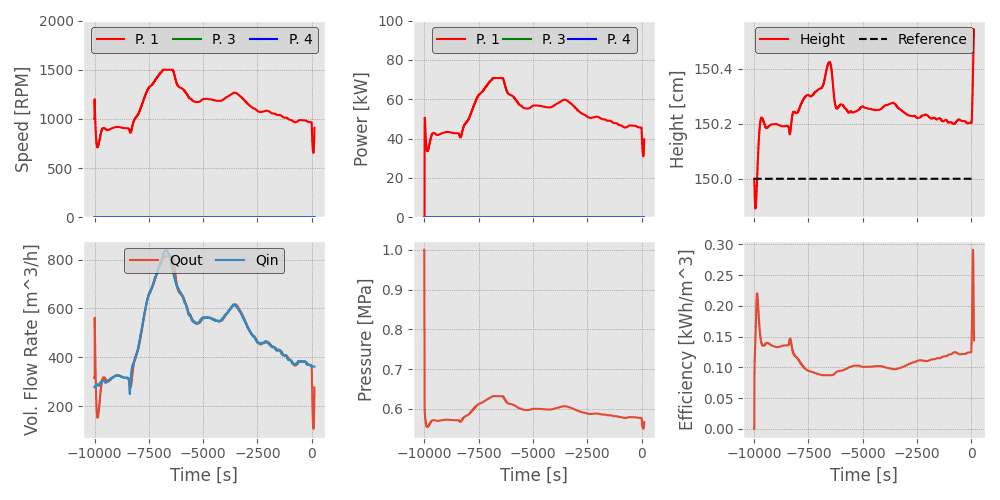

In [5]:
time = np.arange((-h_hist.shape[0]+2)*Ts, (N+1)*Ts,Ts)
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=False)

# Plot 1 - Speed [RPM]
axs[0, 0].step(time,np.hstack([w_hist[0, :],sol_w[0,zs+1:].full().reshape(-1)]), "r", label='P. 1',where='post')
axs[0, 0].step(time,np.hstack([w_hist[1, :],sol_w[1,zs+1:].full().reshape(-1)]), "g", label='P. 3',where='post')
axs[0, 0].step(time,np.hstack([w_hist[2, :],sol_w[2,zs+1:].full().reshape(-1)]), "b", label='P. 4',where='post')
axs[0, 0].set_ylim([0, 2000])
axs[0, 0].set_ylabel('Speed [RPM]')
axs[0, 0].grid(linestyle=':', linewidth='0.5', color='gray')
axs[0, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')


# Plot 2 - Power [kW]
axs[0, 1].step(time,np.hstack([E_hist[0, :],sol_E[0,zs+1:].full().reshape(-1)]), "r", label='P. 1',where='post')
axs[0, 1].step(time,np.hstack([E_hist[1, :],sol_E[1,zs+1:].full().reshape(-1)]), "g", label='P. 3',where='post')
axs[0, 1].step(time,np.hstack([E_hist[2, :],sol_E[2,zs+1:].full().reshape(-1)]), "b", label='P. 4',where='post')
axs[0, 1].set_ylabel('Power [kW]')
axs[0, 1].grid(linestyle=':', linewidth='0.5', color='gray')
axs[0, 1].set_ylim([0, 100])
axs[0, 1].legend(loc='upper center', columnspacing=0.2, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 3 - Height
axs[0, 2].step(time,np.hstack([h_hist,sol_h[zs+1:].full().reshape(-1)]), "r", label='Height',where='post')
axs[0, 2].step(time,h_ref_k[:h_hist.shape[0]+N-1], "k--", label='Reference',where='post')
axs[0, 2].set_ylabel("Height [cm]")
axs[0, 2].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0, 2].set_ylim([0, 250])
axs[0, 2].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 4 - Volumetric Flow Rate
axs[1, 0].step(time,np.hstack([Qout_hist,sol_Qout[zs+1:].full().reshape(-1)]), label='Qout',where='post')
# axs[1, 0].step(time,Qin_k[:h_hist.shape[0]+N-1], label='Qin',where='post')
axs[1, 0].step(time,np.hstack([Qin_hist, np.ones(sol_Qout[zs+1:].shape[0])*Qin_hist[-1]]), label='Qin',where='post')
axs[1, 0].set_ylabel("Vol. Flow Rate [m^3/h]")
axs[1, 0].set_xlabel("Time [s]")
axs[1, 0].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[1, 0].set_ylim([0, 800])
axs[1, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 5 - Pressure
axs[1, 1].step(time,np.hstack([P_hist,sol_P[zs+1:].full().reshape(-1)]), label='Pressure',where='post')
axs[1, 1].set_ylabel("Pressure [MPa]")
axs[1, 1].set_xlabel("Time [s]")
axs[1, 1].grid(linestyle=':', linewidth='0.5', color='gray')

# Plot 6 - effi
axs[1, 2].step(time,np.hstack([effi_hist,sol_effi[zs+1:].full().reshape(-1)]), label='Qout',where='post')
axs[1, 2].grid(linestyle=':', linewidth='0.5', color='gray')
axs[1, 2].set_ylabel("Efficiency [kWh/m^3]")
axs[1, 2].set_xlabel("Time [s]")


plt.tight_layout()
plt.show()
